# Set-Up

In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import logging 
from sklearn.metrics import pairwise_distances

In [3]:
logging.basicConfig(filename='../debug_info.log', encoding='utf-8', level=logging.DEBUG)

# Fetch data

In [18]:
initial_data_url = "https://www.arcgis.com/apps/opsdashboard/index.html#/bda7594740fd40299423467b48e9ecf6"
final_data_url = "https://data.mendeley.com/datasets/kg72dst75p/1"

In [54]:
data_1day = pd.read_csv("../data/Coronavirus_Data_Cases_1a. Per day.csv", sep=";", encoding="latin-1", index_col=0, header=0, thousands=',')
data_1date = pd.read_csv("../data/Coronavirus_Data_Cases_1b. Per date.csv", sep=";", encoding="latin-1", index_col=0, header=0, thousands=',')
data_2day = pd.read_csv("../data/Coronavirus_Data_Cases_2a. Per day_population.csv", sep=";", encoding="latin-1", index_col=0, header=0, thousands=',')
data_2date = pd.read_csv("../data/Coronavirus_Data_Cases_2b. Per date_population.csv", sep=";", encoding="latin-1", index_col=0, header=0, thousands=',')
data_5date = pd.read_csv("../data/Coronavirus_Data_Cases_5a. Per date_popul_surf.csv", sep=";", encoding="latin-1", index_col=0, header=0, thousands=',')
data_5day = pd.read_csv("../data/Coronavirus_Data_Cases_5a. Per day_popul_surf.csv", sep=";", encoding="latin-1", index_col=0, header=0, thousands=',')

# Cleaning Data
## Adjust Data types and columns

In [55]:
def clean_up(dataframe):

    dataframe = dataframe.loc[:, ~dataframe.columns.str.contains('^Unnamed')]
    dataframe = dataframe.apply(pd.to_numeric, args={'coerce'})

    if type(dataframe.index[0])  == str and ('density'.title() in dataframe.index[0]  or 'population'.title() in dataframe.index[0]):

        if '/' not in dataframe.index[1]:

            dataframe_with_metric = dataframe.iloc[0].copy()
            dataframe = dataframe.iloc[1:].copy()
            dataframe.index = dataframe.index.astype(int)
            return (dataframe, dataframe_with_metric)
        
        elif '/' in dataframe.index[1]:

            dataframe_with_metric = dataframe.iloc[0].copy()
            dataframe = dataframe.iloc[1:].copy()
            dataframe.index = pd.to_datetime(dataframe.index, format='%d/%m/%Y')
            return (dataframe, dataframe_with_metric)
    
    elif type(dataframe.index[0])  == str and '/' in dataframe.index[1]:

        if np.nan in dataframe.index:

            dataframe = dataframe.iloc[:-5].copy()
            dataframe_metric = dataframe.iloc[-4:].copy()
            dataframe.index = pd.to_datetime(dataframe.index, format='%d/%m/%Y')
            return dataframe, dataframe_metric
        
        else:

            dataframe.index = pd.to_datetime(dataframe.index, format='%d/%m/%Y')
            return dataframe


    #return dataframe


data_1day = clean_up(data_1day)
data_1date, data_1date_metrics = clean_up(data_1date)
data_2day, data_2day_population = clean_up(data_2day)
data_2date, data_2date_population = clean_up(data_2date)
data_5date, data_5date_density = clean_up(data_5date)
data_5day, data_5day_density = clean_up(data_5day)

In [56]:
#FIXME The index of 1day and 2day dataframe have different types (int and string, respectively) -> should be same
print(data_1date.index[:3]) 
print(data_2date.index[:3])

DatetimeIndex(['2020-01-22', '2020-01-23', '2020-01-24'], dtype='datetime64[ns]', name='Country/Region', freq=None)
DatetimeIndex(['2020-01-22', '2020-01-23', '2020-01-24'], dtype='datetime64[ns]', freq=None)


In [32]:
data_1date.info()

<class 'pandas.core.frame.DataFrame'>
Index: 79 entries, 22/01/2020 to ratio
Columns: 210 entries, US to Diamond Princess-Canada
dtypes: float64(210)
memory usage: 130.2+ KB


In [33]:
data_1day_pct_change = data_1day.pct_change().iloc[1:]


In [34]:
data_1day_pct_change

,US,"Korea, South",China,Taiwan*,Thailand,Japan,Vietnam,Singapore,France,Nepal,...,Anguilla-United Kingdom,British Virgin Islands-United Kingdom,Turks and Caicos Islands-United Kingdom,MS Zaandam,Botswana,Burundi,Sierra Leone,"Bonaire, Sint Eustatius and Saba-Netherlands",Malawi,Falkland Islands (Islas Malvinas)-United Kingdom
Country/Region,,,,,,,,,,,,,,,,,,,,,
2,0.000000,0.000000,0.173358,0.000000,0.500000,0.000000,0.000000,2.000000,0.500000,0.0,...,0.0,0.0,0.000000,0.0,0.333333,0.0,1.0,0.0,0.000000,0.0
3,1.000000,1.000000,0.430793,2.000000,0.666667,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.250000,0.0,0.000000,0.5,0.0,0.0,0.333333,0.0
4,0.000000,0.000000,0.528261,0.000000,0.400000,0.000000,0.000000,0.333333,0.000000,0.0,...,0.0,0.5,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
5,1.500000,0.500000,0.475818,0.333333,0.142857,1.000000,0.000000,0.250000,0.333333,0.0,...,0.0,0.0,0.200000,3.5,0.000000,0.0,1.0,0.0,0.000000,0.0
6,0.000000,0.333333,0.386506,0.250000,0.000000,0.000000,0.000000,0.400000,0.250000,0.0,...,0.5,0.0,-0.166667,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,0.162941,0.012939,0.000985,0.052288,0.083333,0.046624,0.028302,0.079914,0.037130,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
71,0.133920,0.010321,0.000997,0.021739,0.072683,0.115207,0.068807,0.049000,0.088537,0.5,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
72,0.140979,0.009002,0.000862,0.030395,0.058724,0.145546,0.017167,0.061964,0.398132,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0


In [35]:
data_1day_pct_change_accumulative_avg = data_1day_pct_change.expanding().mean()

In [36]:
data_1day_pct_change_accumulative_avg.head(10)

,US,"Korea, South",China,Taiwan*,Thailand,Japan,Vietnam,Singapore,France,Nepal,...,Anguilla-United Kingdom,British Virgin Islands-United Kingdom,Turks and Caicos Islands-United Kingdom,MS Zaandam,Botswana,Burundi,Sierra Leone,"Bonaire, Sint Eustatius and Saba-Netherlands",Malawi,Falkland Islands (Islas Malvinas)-United Kingdom
Country/Region,,,,,,,,,,,,,,,,,,,,,
2,0.000000,0.000000,0.173358,0.000000,0.500000,0.000000,0.000000,2.000000,0.500000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000,1.000000,0.0,0.000000,0.0
3,0.500000,0.500000,0.302075,1.000000,0.583333,0.000000,0.000000,1.000000,0.250000,0.0,...,0.000000,0.000000,0.125000,0.000000,0.166667,0.250000,0.500000,0.0,0.166667,0.0
4,0.333333,0.333333,0.377471,0.666667,0.522222,0.000000,0.000000,0.777778,0.166667,0.0,...,0.000000,0.166667,0.083333,0.000000,0.111111,0.166667,0.333333,0.0,0.111111,0.0
5,0.625000,0.375000,0.402057,0.583333,0.427381,0.250000,0.000000,0.645833,0.208333,0.0,...,0.000000,0.125000,0.112500,0.875000,0.083333,0.125000,0.500000,0.0,0.083333,0.0
6,0.500000,0.366667,0.398947,0.516667,0.341905,0.200000,0.000000,0.596667,0.216667,0.0,...,0.100000,0.100000,0.056667,0.700000,0.066667,0.100000,0.400000,0.0,0.066667,0.0
7,0.416667,0.305556,0.484930,0.530556,0.409921,0.291667,0.000000,0.497222,0.180556,0.0,...,0.083333,0.083333,0.047222,0.583333,0.055556,0.083333,0.333333,0.0,0.055556,0.0
8,0.357143,0.261905,0.430642,0.454762,0.351361,0.250000,0.000000,0.487415,0.154762,0.0,...,0.071429,0.071429,0.040476,0.500000,0.047619,0.071429,0.285714,0.0,0.047619,0.0
9,0.312500,0.229167,0.418992,0.413542,0.307440,0.290179,0.000000,0.463988,0.160417,0.0,...,0.062500,0.062500,0.035417,0.437500,0.041667,0.062500,0.250000,0.0,0.041667,0.0
10,0.322222,0.398148,0.395107,0.379938,0.312963,0.298341,0.222222,0.438075,0.142593,0.0,...,0.055556,0.055556,0.031481,0.388889,0.037037,0.055556,0.222222,0.0,0.037037,0.0


In [37]:
data_1day_pct_change > data_1day_pct_change_accumulative_avg * 0.2 

,US,"Korea, South",China,Taiwan*,Thailand,Japan,Vietnam,Singapore,France,Nepal,...,Anguilla-United Kingdom,British Virgin Islands-United Kingdom,Turks and Caicos Islands-United Kingdom,MS Zaandam,Botswana,Burundi,Sierra Leone,"Bonaire, Sint Eustatius and Saba-Netherlands",Malawi,Falkland Islands (Islas Malvinas)-United Kingdom
Country/Region,,,,,,,,,,,,,,,,,,,,,
2,False,False,True,False,True,False,False,True,True,False,...,False,False,False,False,True,False,True,False,False,False
3,True,True,True,True,True,False,False,False,False,False,...,False,False,True,False,False,True,False,False,True,False
4,False,False,True,False,True,False,False,True,False,False,...,False,True,False,False,False,False,False,False,False,False
5,True,True,True,True,True,True,False,True,True,False,...,False,False,True,True,False,False,True,False,False,False
6,False,True,True,True,False,False,False,True,True,False,...,True,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,True,False,False,True,True,True,True,True,True,False,...,False,False,False,False,False,False,False,False,False,False
71,True,False,False,True,True,True,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False
72,True,False,False,True,True,True,True,True,True,False,...,False,False,False,False,False,False,False,False,False,False


## Choose relevant columns

In [38]:
def truncate_date(data_date):
    last_day = data_date.loc['04/04/2020']
    last_day = last_day.sort_values(ascending=False)
    last_day = last_day[:30]
    data_date = data_date[last_day.index]
    return data_date

In [39]:
#The 1b (1date) dataset contains five additional rows with statistics 
#Truncate them for consistency of the dataset (each row refers to a specific date)

In [40]:
data_1date_trunc = truncate_date(data_1date)[:-5]
data_2date_trunc = truncate_date(data_2date)
data_5date_trunc = truncate_date(data_5date)

In [41]:
def truncate_day(data_day, data_date):
    data_day = data_day.copy()
    columns = list(set(data_day.columns) & set(data_date.columns))
    first_occ = data_date[columns] > 0 
    first_occ = first_occ.apply(pd.Series.idxmax)
    first_occ = pd.to_datetime(first_occ, dayfirst = True)
    first_occ = first_occ.sort_values(ascending = True)
    first_occ = first_occ[:30]
    data_day = data_day[first_occ.index] 
    return data_day

In [42]:
data_1day_trunc = truncate_day(data_1day, data_1date)   
data_2day_trunc = truncate_day(data_2day, data_2date)
data_5day_trunc = truncate_day(data_5day, data_5date)

# Visualizations (Cases per Day)

## Plot Cases

In [185]:
def plot_cases(data, ax, marker='s', markersize=2, is_day=True, is_last=False):
    ax.plot(data
            , marker=marker
            , markersize=markersize
            , label=data.columns 
            )
    ax.legend(loc='upper left')
    
    if is_last:
        start = 4
        stop = 30
        step = 5
        ax.set_xlabel('Date')
    elif is_day:
        start = 0
        stop = 90
        step = 10 
        ax.set_xlabel('Day')
    else:
        start = 4
        stop = 40
        step = 5
        ax.set_xlabel('Date')

    ax.set_xticks([x for x in range(start, stop, step)])
    for label in ax.get_xticklabels()[1::2]:
        label.set_visible(False)
    

### Absolute cases

--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\sebas\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1104, in emit
    self.flush()
  File "c:\Users\sebas\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1084, in flush
    self.stream.flush()
OSError: [Errno 22] Invalid argument
Call stack:
  File "c:\Users\sebas\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\sebas\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "C:\Users\sebas\AppData\Roaming\Python\Python310\site-packages\ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "C:\Users\sebas\AppData\Roaming\Python\Python310\site-packages\traitlets\config\application.py", line 982, in launch_instance
    app.start()
  File "C:\Users\sebas\AppData\Roaming\Python\Python310\

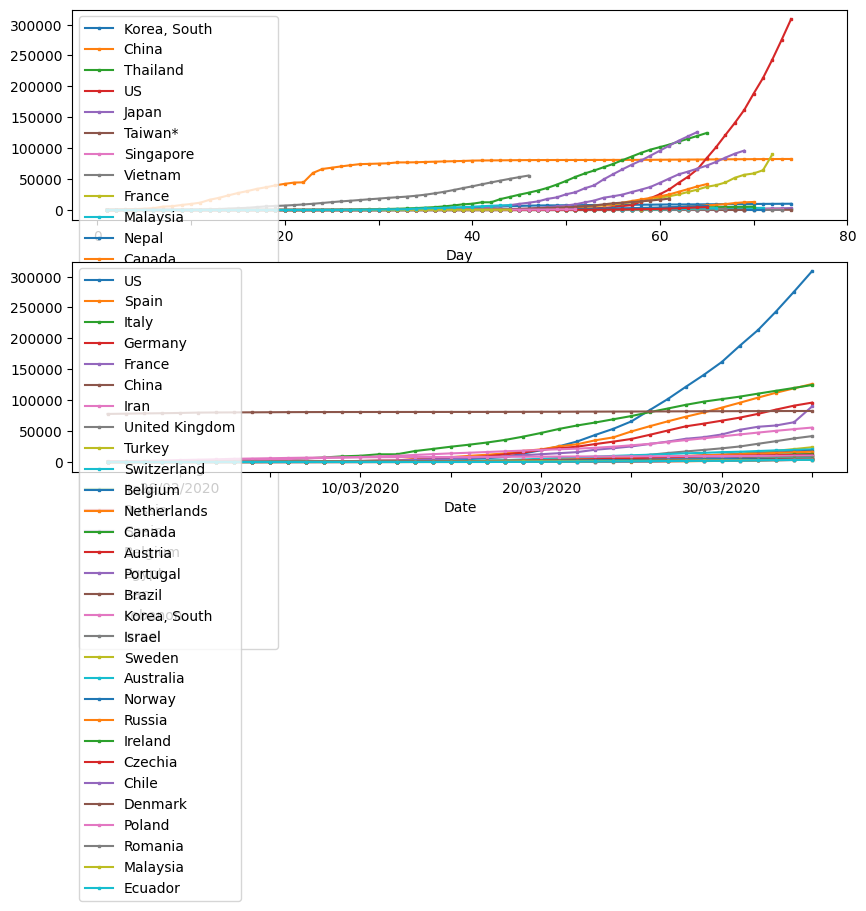

In [186]:
fig, axes = plt.subplots(figsize=(10, 6), nrows=2)

plot_cases(data_1day_trunc
        , axes[0]
        )
plot_cases(data_1date_trunc.loc['25/02/2020':]
        , axes[1]
        , is_day=False
        )

fig.savefig("../figures/Fig1.png")
plt.show() 
#TODO Split legend like in paper

## Cases per 1 million

--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\sebas\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1104, in emit
    self.flush()
  File "c:\Users\sebas\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1084, in flush
    self.stream.flush()
OSError: [Errno 22] Invalid argument
Call stack:
  File "c:\Users\sebas\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\sebas\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "C:\Users\sebas\AppData\Roaming\Python\Python310\site-packages\ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "C:\Users\sebas\AppData\Roaming\Python\Python310\site-packages\traitlets\config\application.py", line 982, in launch_instance
    app.start()
  File "C:\Users\sebas\AppData\Roaming\Python\Python310\

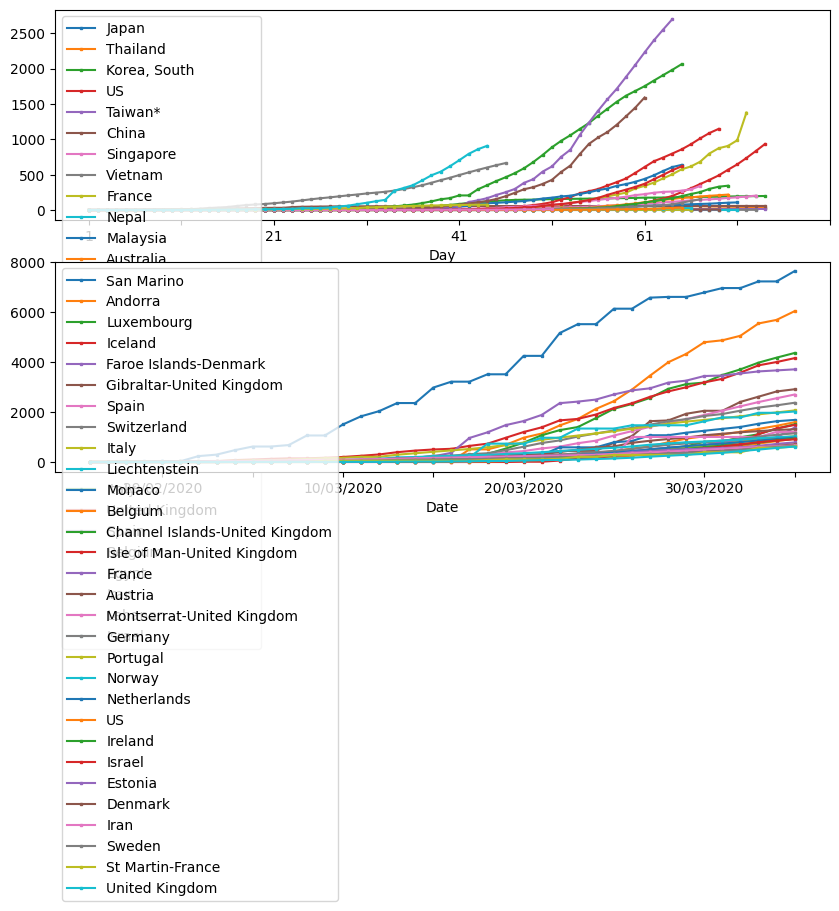

In [187]:
fig, axes = plt.subplots(figsize=(10, 6), nrows=2)

plot_cases(data_2day_trunc
        , axes[0])
plot_cases(data_2date_trunc.loc['25/02/2020':]
        , axes[1]
        , is_day=False
        )

fig.savefig("../figures/Fig2.png")
plt.show() 

## Cases per population per land

--- Logging error ---
Traceback (most recent call last):
  File "c:\Users\sebas\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1104, in emit
    self.flush()
  File "c:\Users\sebas\AppData\Local\Programs\Python\Python310\lib\logging\__init__.py", line 1084, in flush
    self.stream.flush()
OSError: [Errno 22] Invalid argument
Call stack:
  File "c:\Users\sebas\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\sebas\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "C:\Users\sebas\AppData\Roaming\Python\Python310\site-packages\ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "C:\Users\sebas\AppData\Roaming\Python\Python310\site-packages\traitlets\config\application.py", line 982, in launch_instance
    app.start()
  File "C:\Users\sebas\AppData\Roaming\Python\Python310\

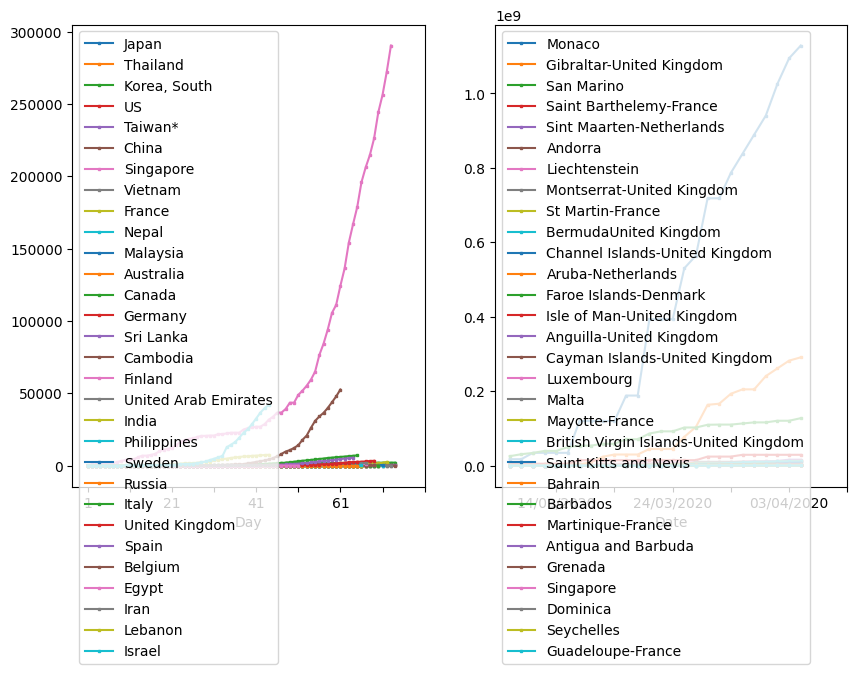

In [188]:
fig, axes = plt.subplots(figsize=(10, 6), ncols=2)

plot_cases(data_5day_trunc, axes[0])
plot_cases(data_5date_trunc.loc['10/03/2020':'04/04/2020']
        , axes[1]
        , is_day=False
        , is_last=True
        )

fig.savefig("../figures/Fig5.png")
plt.show() 

# Agglomerative Clustering

In [51]:
from scipy.cluster.hierarchy import dendrogram, linkage

In [189]:
def plot_hierarchy(data, ax):
    data = data.transpose()
    linkage_matrix = linkage(data, method='single', metric='euclidean')
    R = dendrogram(linkage_matrix)

    country_names = data.index.to_list()
    temp = {R['leaves'][i]: country_names[i] for i in range(len(R['leaves']))}
    def llf(i):
        return '{}---{}'.format(temp[i], i)

    dendrogram(
        linkage_matrix
        , ax=ax
        , orientation='right'
        , leaf_label_func=llf
    )
    ax.set_xticks([])

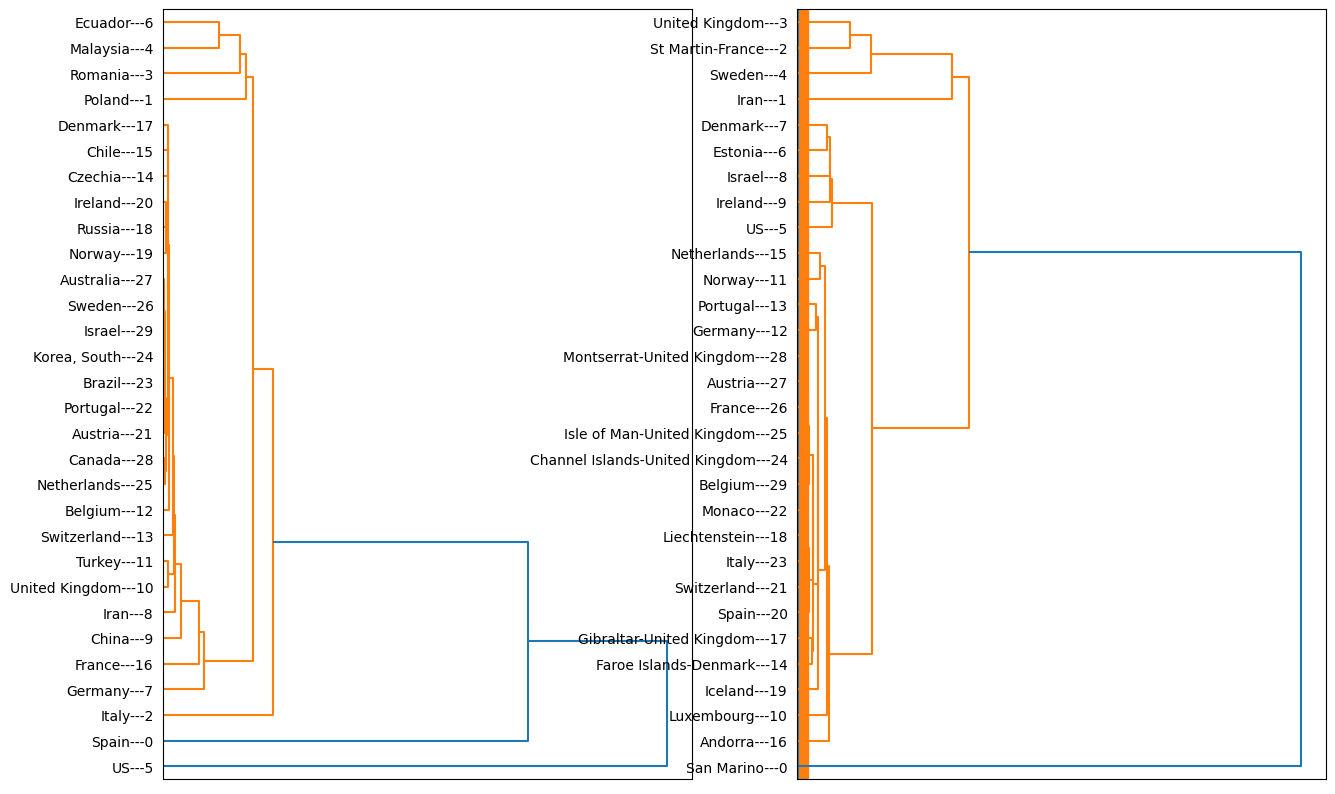

In [190]:
fig, axes = plt.subplots(figsize=(15, 10), ncols=2)

plot_hierarchy(data_1date_trunc, ax=axes[0])
plot_hierarchy(data_2date_trunc, ax=axes[1])

plt.savefig('../figures/Clustering1')